# Exercise (with another solution)

In this exercise, you will apply what you've learned to build, train, and evaluate a neural network to classify handwritten digits from the famous MNIST dataset.


# Step 1: Import the libraries

Step 1: Setup and Imports
First, we import the necessary libraries and, most importantly, set up our device. This ensures our code will use a GPU for faster training if one is available.

In [36]:
# --- Core PyTorch and data handling libraries ---
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import random

# --- Libraries for visualization and analysis ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # For a prettier confusion matrix

# --- Set up the device for training ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

Using cuda device


# Step 2: Load the dataset and visualize the dataset
We can load the MNIST dataset from ``torchvision`` with the following parameters:

 - **root** is the path where the train/test data is stored,
 - **train** specifies training or test dataset,
 - **download=True** downloads the data from the internet if it’s not available at root.
 - **transform** and **target_transform** specify the feature and label transformations
 

Besides, we can index Datasets manually like a list: train_set[index]. We use matplotlib to visualize some samples in our training data.


In [37]:
# Define transforms to scale and normalize the data to zero mean and unit variance
mnist_mean = 0.1307
mnist_std = 0.3081

transform = transforms.Compose([
    # Resize the image to 28x28 pixels
    transforms.Resize((28, 28)),
    # Convert the image to a tensor in the range [0, 1]
    transforms.ToTensor(),
    # Normalize the tensor with mean and standard deviation to have zero mean and unit variance
    transforms.Normalize((mnist_mean,), (mnist_std,)) # Why do you think we do this?
])

train_set = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = transform
)

test_set = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = transform
)
print(f"Number of training samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")

Number of training samples: 60000
Number of test samples: 10000


Now let's visualize some samples in our training data.

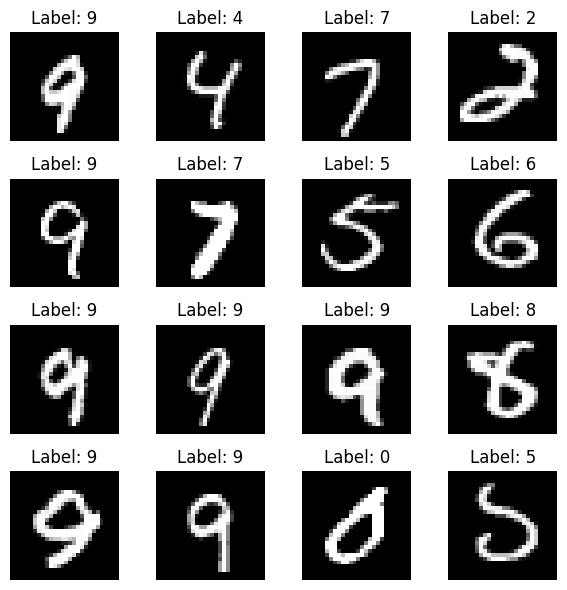

In [38]:
# Visualize some samples (unnormalize for display)
def imshow_normalized(tensor_img):
    img = tensor_img.clone().cpu().numpy()
    img = img * mnist_std + mnist_mean  # Unnormalize
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

plt.figure(figsize = (6, 6))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(train_set) - 1)
    img, label = train_set[sample_idx]
    plt.subplot(rows, cols, i)
    imshow_normalized(img)
    plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

# Step 3: Preparing your data for training with DataLoaders




We'll use `DataLoader` to feed data to our network in batches. This is more efficient than processing one image at a time. We'll also shuffle the training data to ensure the model doesn't learn the order of the images.

In [39]:
# Create DataLoaders for batching
BATCH_SIZE = 64

train_loader = DataLoader(
    dataset = train_set,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_set,
    batch_size = BATCH_SIZE,
    shuffle = False
)
print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in test set: {len(test_loader)}")

Number of batches in training set: 938
Number of batches in test set: 157


# Step 4: Define your own network model

**Your Task**: Define the architecture for your neural network. You can start with the provided structure and then experiment. Try adding or removing layers, or changing the number of neurons. Have a think about how these changes might affect the model's ability to learn from the data.



In [40]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # Initialize the attributes of parent class

        # This layer flattens the 28x28 images into a 784-dimensional vector
        self.flatten = nn.Flatten()

        # This is an ordered container of layers.
        # Data will pass through them in the sequence they are defined.
        self.linear_relu_stack = nn.Sequential(
            # First fully connected layer: 784 inputs, 512 outputs
            nn.Linear(28*28, 512),
            # ReLU activation to introduce non-linearity
            nn.ReLU(inplace=True),
            # Second fully connected layer: 512 inputs, 512 outputs
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            # Third fully connected layer: 512 inputs, 512 outputs
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            # Output layer: 512 inputs, 10 outputs (one for each class)
            nn.Linear(512, 10),
        )

    def forward(self, x):
        # First, flatten the input image
        x = self.flatten(x)
        # Then, pass the flattened input through the sequential layers
        logits = self.linear_relu_stack(x)
        return logits

# Initialize the model and move it to the appropriate device
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Step 5: Train your own network model

Here, we'll use the robust `train_loop` and `test_loop` functions from our lab. This organized approach allows us to clearly separate the training and validation logic.

**Your Task:** Set the hyperparameters. Experiment with different learning rates and numbers of epochs to see how they affect the model's performance.


In [41]:
# --- Hyperparameters ---
learning_rate = 1e-2


# --- Loss Function and Optimizer ---
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Optional: LR scheduler example (decay after 10 epochs)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # Decay LR by a factor of 0.1 every 10 epochs
# See: https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html

def train_loop(dataloader, model, loss_fn, optimizer, device):
    # Put the model in training mode
    model.to(device)
    model.train()

    total_samples = 0
    train_loss = 0.0
    train_accuracy = 0.0

    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        batch_size = images.shape[0]
        total_samples += batch_size

        # Forward pass: compute predicted outputs by passing inputs to the model
        logits = model(images)

        # Compute the loss
        loss = loss_fn(logits, labels)
        
        # Zero the gradients before running the backward pass
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Log loss and accuracy
        train_loss += loss.item() * batch_size
        acc = (logits.argmax(dim=1) == labels).type(torch.float).sum().item()
        train_accuracy += acc

    # Compute average loss and accuracy over all samples
    avg_loss = train_loss / total_samples
    avg_accuracy = train_accuracy / total_samples
    return avg_loss, avg_accuracy


def test_loop(dataloader, model, loss_fn, device):
    # Put the model in evaluation mode
    model.to(device)
    model.eval()

    total_samples = 0
    test_loss = 0.0
    test_accuracy = 0.0

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            batch_size = images.shape[0]
            total_samples += batch_size

            # Forward pass: compute predicted outputs by passing inputs to the model
            logits = model(images)

            # Compute the loss
            loss = loss_fn(logits, labels)

            # Log loss and accuracy
            test_loss += loss.item() * batch_size
            acc = (logits.argmax(dim=1) == labels).type(torch.float).sum().item()
            test_accuracy += acc

    # Compute average loss and accuracy over all samples
    avg_loss = test_loss / total_samples
    avg_accuracy = test_accuracy / total_samples
    return avg_loss, avg_accuracy

In [42]:
# Run training and testing loops
epochs = 12
train_eval_logs = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}

for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")
    print("-" * 50)

    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer, device)
    # Step the LR scheduler
    lr_scheduler.step()
    test_loss, test_accuracy = test_loop(test_loader, model, loss_fn, device)

    train_eval_logs["train_loss"].append(train_loss)
    train_eval_logs["train_accuracy"].append(train_accuracy)
    train_eval_logs["test_loss"].append(test_loss)
    train_eval_logs["test_accuracy"].append(test_accuracy)


    print(f"Epoch {epoch:02d}: Train loss={train_loss:.4f}, Train acc={100*train_accuracy:5.2f}% | "
          f"Test loss={test_loss:.4f}, Test acc={100*test_accuracy:5.2f}%")

print("\nTraining complete!")

    


Epoch 1/12
--------------------------------------------------
Epoch 01: Train loss=1.0378, Train acc=73.44% | Test loss=0.3512, Test acc=90.08%

Epoch 2/12
--------------------------------------------------
Epoch 02: Train loss=0.3105, Train acc=90.94% | Test loss=0.2539, Test acc=92.78%

Epoch 3/12
--------------------------------------------------
Epoch 03: Train loss=0.2417, Train acc=92.84% | Test loss=0.2153, Test acc=93.87%

Epoch 4/12
--------------------------------------------------
Epoch 04: Train loss=0.1976, Train acc=94.23% | Test loss=0.1794, Test acc=94.69%

Epoch 5/12
--------------------------------------------------
Epoch 05: Train loss=0.1663, Train acc=95.18% | Test loss=0.1524, Test acc=95.57%

Epoch 6/12
--------------------------------------------------
Epoch 06: Train loss=0.1424, Train acc=95.89% | Test loss=0.1653, Test acc=95.09%

Epoch 7/12
--------------------------------------------------
Epoch 07: Train loss=0.1239, Train acc=96.42% | Test loss=0.1250, T

# Step 6: Evaluate the result on the test dataset and analyze the performance on the whole dataset

You can show the best performance with any update mthods.




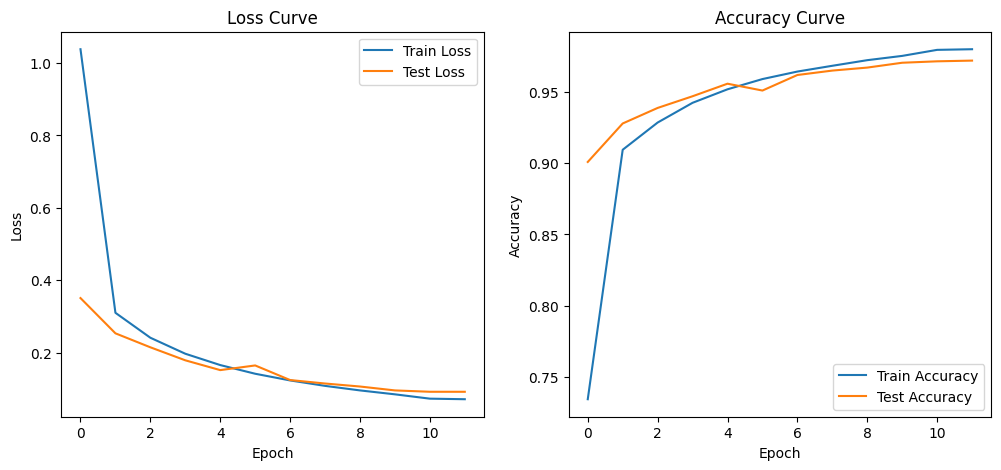

In [43]:
# Plot the learning curves for Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_eval_logs['train_loss'], label='Train Loss')
plt.plot(train_eval_logs['test_loss'], label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_eval_logs['train_accuracy'], label='Train Accuracy')
plt.plot(train_eval_logs['test_accuracy'], label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

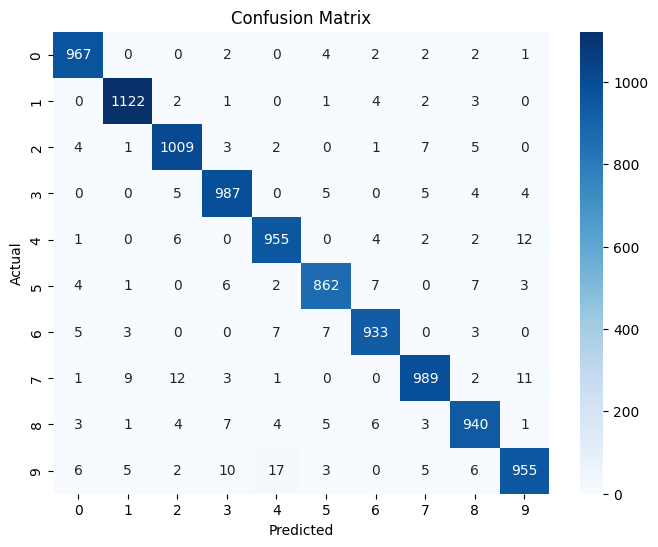

In [44]:
# Get all predictions for the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Compute the confusion matrix
cfm = pd.crosstab(pd.Series(all_labels, name='Actual'),
                  pd.Series(all_preds, name='Predicted'))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

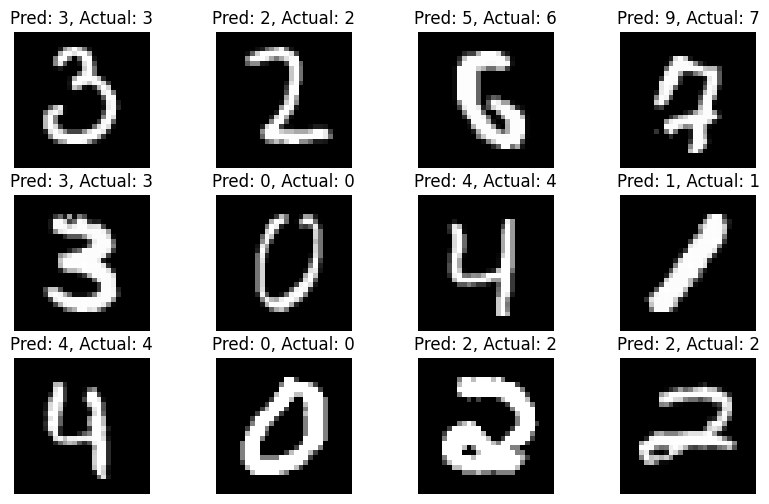

In [45]:
# Let's also visualize some random test samples along with their predicted and actual labels
indices = torch.randperm(len(test_set))[:12].tolist()
plt.figure(figsize = (10, 6))
for i, idx in enumerate(indices):
    ax = plt.subplot(3, 4, i + 1)
    img, label = test_set[idx]
    img = img.to(device).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    imshow_normalized(img.squeeze())
    plt.title(f"Pred: {pred}, Actual: {label}")
    plt.axis('off')

# Step 7: Any other thought on the training network?
 - How to save the training file?
 - How to speed the training process?


It's good practice to save your model's learned weights (state_dict) after training.

In [33]:
# Save model
PATH = "mnist_model.pth"
torch.save(model.state_dict(), PATH)
print(f"Model saved to {PATH}")

# # To load the model later, you can use:
# model_loaded = NeuralNetwork().to(device)
# model_loaded.load_state_dict(torch.load(PATH))
# model_loaded.eval()

Model saved to mnist_model.pth


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)